In [21]:
#import modul/library
import pandas as pd
import numpy as np
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import layers, optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation, Flatten
from keras.callbacks import EarlyStopping, TensorBoard
from keras import backend as K
from collections import defaultdict
from sklearn import metrics

from Cleansing import clean

## EDA & Pre Processing

In [2]:
#read data training
trains = pd.read_csv("dataset/train_preprocess.tsv.txt", sep='\t', names=['Kalimat','Sentiment'])
trains.head()

,Kalimat,Sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [3]:
#check data volume
trains.shape

(11000, 2)

In [4]:
#check data null
trains.isna().sum()

Kalimat      0
Sentiment    0
dtype: int64

In [5]:
#check total data duplicated
trains.duplicated().sum()

67

In [6]:
#Remove data duplicated
trainn = trains.drop_duplicates(inplace=False, ignore_index=True)

In [7]:
#check data voulume after remove duplicated
trainn.shape

(10933, 2)

In [8]:
#check distribution label
trainn.Sentiment.value_counts()

positive    6383
negative    3412
neutral     1138
Name: Sentiment, dtype: int64

In [9]:
#Clean data training
trainn['Clean'] = trainn.Kalimat.apply(clean)
trainn.head()

C:\Users\BAV USER\AppData\Local\Temp\ipykernel_11376\3965060814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainn['Clean'] = trainn.Kalimat.apply(clean)


,Kalimat,Sentiment,Clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung dimiliki pengusaha pabrik puluhan terke...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k212 mmbri hujjah partai diw...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatra bandung nya nya...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya unboxing paket barang nya b...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh mahasiswa sombong kasih kartu kuning bela...


## Neural Network (MLP Classifier)

### Feature Extraction

In [10]:
dataprep = trainn.Clean.to_list()
cv_nn = CountVectorizer()
cv_nn.fit(dataprep)

X = cv_nn.transform(dataprep)
print('Feature Extraction done')
print (X)

Feature Extraction done
  (0, 918)	1
  (0, 1013)	1
  (0, 1163)	1
  (0, 1488)	1
  (0, 1713)	1
  (0, 2098)	1
  (0, 3742)	1
  (0, 3794)	2
  (0, 4086)	1
  (0, 5365)	1
  (0, 5759)	1
  (0, 6297)	1
  (0, 6474)	1
  (0, 7329)	1
  (0, 8398)	1
  (0, 8470)	1
  (0, 9197)	2
  (0, 9228)	1
  (0, 10067)	1
  (0, 10306)	1
  (0, 10998)	1
  (0, 11786)	1
  (0, 11824)	1
  (0, 12861)	1
  (0, 14113)	1
  :	:
  (10932, 911)	1
  (10932, 1168)	1
  (10932, 1224)	1
  (10932, 1383)	1
  (10932, 1485)	1
  (10932, 1867)	1
  (10932, 1999)	1
  (10932, 4020)	1
  (10932, 4763)	1
  (10932, 4764)	1
  (10932, 6212)	1
  (10932, 6312)	1
  (10932, 7406)	1
  (10932, 7735)	1
  (10932, 7873)	1
  (10932, 8026)	1
  (10932, 8027)	2
  (10932, 10067)	3
  (10932, 11410)	1
  (10932, 11411)	1
  (10932, 12207)	1
  (10932, 12243)	1
  (10932, 14653)	1
  (10932, 14809)	1
  (10932, 15531)	1


In [11]:
pickle.dump(cv_nn, open('asset/feature/feature_nn.pickle','wb'))

### Train Model NN

In [12]:
Y = trainn.Sentiment
Y.head()

0    positive
1     neutral
2    positive
3    positive
4    negative
Name: Sentiment, dtype: object

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

In [14]:
model_nn = MLPClassifier()
model_nn.fit(X_train, Y_train)

print('Training selesai')

Training selesai


In [15]:
pickle.dump(model_nn, open('asset/model/model_nn.pickle','wb'))

### Evaluation NN

In [16]:
test = model_nn.predict(X_test)

print ('testing selesai')
print(classification_report(Y_test, test))

testing selesai
              precision    recall  f1-score   support

    negative       0.68      0.72      0.70       664
     neutral       0.76      0.57      0.65       259
    positive       0.84      0.85      0.84      1264

    accuracy                           0.78      2187
   macro avg       0.76      0.71      0.73      2187
weighted avg       0.78      0.78      0.78      2187



In [17]:
# Create a KFold object with 5 splits and a fixed random state
Kf = KFold(n_splits=5, shuffle=True, random_state=42)
akurasi = []

In [18]:
for iteration, data in enumerate(Kf.split(X), start=1):
    data_train = X[data[0]]
    target_train = Y[data[0]]

    data_test = X[data[1]]
    target_test = Y[data[1]]

    clf = MLPClassifier()
    clf.fit(data_train, target_train)
    
    pred = clf.predict(data_test)
    akrsi = accuracy_score(target_test,pred)

    print("Training ke: ", iteration)
    print("---")
    print(classification_report(target_test,pred))

akurasi.append(akrsi)
print("rata-rata akurasi: ", np.mean(akurasi))

Training ke:  1
---
              precision    recall  f1-score   support

    negative       0.72      0.74      0.73       690
     neutral       0.71      0.54      0.61       220
    positive       0.85      0.87      0.86      1277

    accuracy                           0.80      2187
   macro avg       0.76      0.72      0.73      2187
weighted avg       0.79      0.80      0.79      2187

Training ke:  2
---
              precision    recall  f1-score   support

    negative       0.70      0.73      0.71       667
     neutral       0.69      0.56      0.62       219
    positive       0.86      0.87      0.86      1301

    accuracy                           0.79      2187
   macro avg       0.75      0.72      0.73      2187
weighted avg       0.79      0.79      0.79      2187

Training ke:  3
---
              precision    recall  f1-score   support

    negative       0.72      0.71      0.71       695
     neutral       0.68      0.57      0.62       213
    positive   

### Predict Test NN

In [19]:
ori = '''
sabar sik ae rek'''

te = cv_nn.transform([clean(ori)])
res = model_nn.predict(te)[0]

print(ori)
print('sentiment:', res)


sabar sik ae rek
sentiment: negative


## LSTM (Long-short Term Memory)

### Feature Extraction LSTM

In [22]:
neg = trainn.loc[trainn.Sentiment == 'negative'].Clean.tolist()
neu = trainn.loc[trainn.Sentiment == 'neutral'].Clean.tolist()
pos = trainn.loc[trainn.Sentiment == 'positive'].Clean.tolist()

neg_sntmnt = trainn.loc[trainn.Sentiment == 'negative'].Sentiment.tolist()
neu_sntmnt = trainn.loc[trainn.Sentiment == 'neutral'].Sentiment.tolist()
pos_sntmnt = trainn.loc[trainn.Sentiment == 'positive'].Sentiment.tolist()

In [23]:
total_data = pos + neu + neg
labels = pos_sntmnt + neu_sntmnt + neg_sntmnt

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6383, Neu: 1138, Neg: 3412
Total data: 10933


In [24]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('asset/feature/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('asset/feature/x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [25]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('asset/feature/y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


### Train Model LSTM

In [26]:
file = open("asset/feature/x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("asset/feature/y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [27]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 78, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________


c:\Users\BAV USER\Python\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Epoch 1/10
875/875 [==============================] - 93s 103ms/step - loss: 0.5026 - accuracy: 0.8024 - val_loss: 0.3743 - val_accuracy: 0.8610
Epoch 2/10
875/875 [==============================] - 86s 98ms/step - loss: 0.2358 - accuracy: 0.9121 - val_loss: 0.3990 - val_accuracy: 0.8573
Epoch 2: early stopping


### Evaluation LSTM

In [28]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 1s 12ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       668
           1       0.86      0.68      0.76       231
           2       0.87      0.95      0.91      1288

    accuracy                           0.86      2187
   macro avg       0.85      0.79      0.82      2187
weighted avg       0.86      0.86      0.85      2187



In [29]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

c:\Users\BAV USER\Python\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


69/69 [==============================] - 1s 10ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       668
           1       0.82      0.71      0.76       231
           2       0.91      0.92      0.91      1288

    accuracy                           0.86      2187
   macro avg       0.84      0.81      0.82      2187
weighted avg       0.86      0.86      0.86      2187



c:\Users\BAV USER\Python\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


69/69 [==============================] - 1s 11ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       668
           1       0.72      0.78      0.75       231
           2       0.88      0.94      0.91      1288

    accuracy                           0.85      2187
   macro avg       0.81      0.81      0.81      2187
weighted avg       0.85      0.85      0.85      2187



c:\Users\BAV USER\Python\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


69/69 [==============================] - 1s 10ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       668
           1       0.82      0.70      0.76       231
           2       0.90      0.92      0.91      1288

    accuracy                           0.86      2187
   macro avg       0.84      0.80      0.82      2187
weighted avg       0.86      0.86      0.86      2187



c:\Users\BAV USER\Python\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


69/69 [==============================] - 1s 11ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       668
           1       0.79      0.64      0.71       231
           2       0.88      0.92      0.90      1288

    accuracy                           0.84      2187
   macro avg       0.82      0.77      0.79      2187
weighted avg       0.84      0.84      0.84      2187



c:\Users\BAV USER\Python\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


69/69 [==============================] - 1s 12ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       668
           1       0.78      0.74      0.76       231
           2       0.90      0.91      0.91      1288

    accuracy                           0.85      2187
   macro avg       0.82      0.81      0.82      2187
weighted avg       0.85      0.85      0.85      2187




Rata-rata Accuracy:  0.8526748971193416


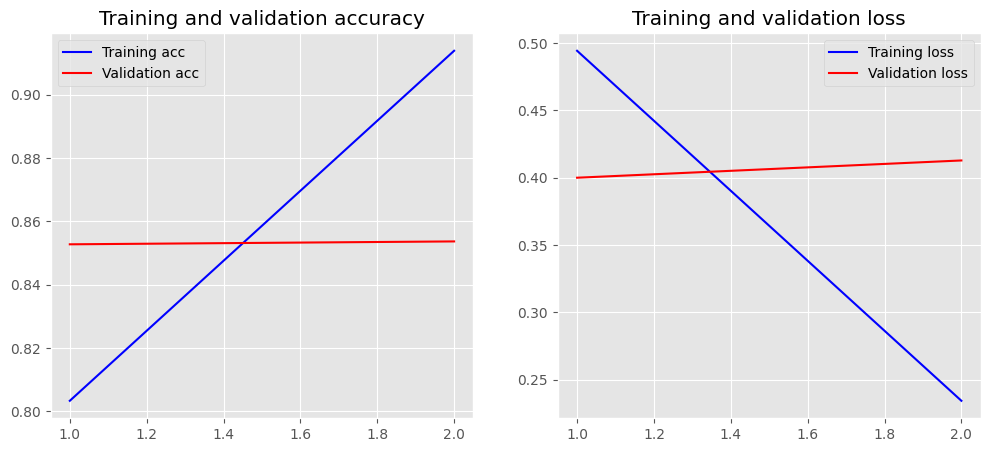

In [30]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [33]:
model.save('asset/model/model_lstm.h5')
print("Model has created!")

Model has created!


### Predict Test LSTM

In [32]:
input_text = """
sabar dahulu"""

sentiment = ['negative', 'neutral', 'positive']

text = [clean(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model_lstm = load_model('asset/model/model_lstm.h5')
prediction = model_lstm.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 431ms/step
Text:  sabar
Sentiment:  positive
